<a href="https://colab.research.google.com/github/ankit-rathi/Data-Science-with-Python/blob/master/Tradevesting/myStocks_Portfolio_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import datetime
import pytz
tz_NY = pytz.timezone('Asia/Kolkata')
datetime_NY = datetime.datetime.now(tz_NY)
print("Run date time (IST):", datetime_NY.strftime("%Y-%m-%d %H:%M:%S"))

gen_output = 0

Run date time (IST): 2023-07-30 11:51:54


In [2]:
# install libraries
!pip install yfinance
!pip install pandas-ta
#!pip install talib-binary

In [3]:
# import libraries

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')
import pandas_datareader.data as web
import yfinance as yfin
#import talib
yfin.pdr_override()
import pandas_ta as ta

In [4]:
# set start and end date
start_date = (datetime.date.today() + datetime.timedelta(days=-5*365)).strftime('%Y-%m-%d')
end_date = (datetime.date.today() + datetime.timedelta(days=1)).strftime('%Y-%m-%d')



In [5]:
# fetch nifty200 scrips

import pandas as pd
import numpy as np

mypf = pd.read_csv('https://raw.githubusercontent.com/ankit-rathi/Data-Science-with-Python/master/Tradevesting/myProspectsScrips.csv')

myts = pd.read_csv('https://raw.githubusercontent.com/ankit-rathi/Data-Science-with-Python/master/Tradevesting/myTransactionsReport.csv')

mypf = mypf[mypf['InPortfolio'] == 1]

stock_n100 = mypf['Symbol'].unique()

exclude = ['CADILAHC','MMTC']

stock_n100 = mypf[~mypf['Symbol'].isin(exclude) ]['Symbol'].unique()

stock_ids = stock_n100

#mypf = mypf[mypf.Forecast.notnull()]
#stock_ids = mypf['Symbol'].unique()

stock_ids.sort()
stock_ids

array(['5PAISA', 'AAVAS', 'AMARAJABAT', 'AMBUJACEM', 'BAJAJFINSV',
       'BAJAJHIND', 'BANDHANBNK', 'BATAINDIA', 'BAYERCROP', 'CAMS',
       'CDSL', 'CLEAN', 'DMART', 'EICHERMOT', 'EMAMILTD', 'FINEORG',
       'GICRE', 'GILLETTE', 'GLAND', 'HDFCAMC', 'HDFCBANK', 'ICICIGI',
       'INDIGOPNTS', 'INDUSINDBK', 'INFY', 'IRCTC', 'ITBEES', 'J&KBANK',
       'JMFINANCIL', 'JUBLFOOD', 'KOTAKBANK', 'LTIM', 'LUXIND',
       'METROPOLIS', 'NIACL', 'NMDC', 'PAGEIND', 'PIDILITIND', 'PNB',
       'RAJESHEXPO', 'RELAXO', 'ROSSARI', 'SAIL', 'SRF', 'STARHEALTH',
       'SUNTV', 'TCS', 'TEAMLEASE', 'UJJIVANSFB', 'VAIBHAVGBL',
       'VALIANTORG', 'WIPRO'], dtype=object)

In [6]:
# function to compute stock attributes
def get_common_features():
  def stock_prec_dev(stock_symbol):
      #stock_symbol = 'ULTRACEMCO.NS'
      short_window = 20
      mid_window = 50
      long_window = 200
      moving_avg = 'SMA'

      # import the closing price data of the stock for the aforementioned period of time in Pandas dataframe
      start = datetime.datetime(*map(int, start_date.split('-')))
      end = datetime.datetime(*map(int, end_date.split('-')))
      stock_df = yfin.Ticker(stock_symbol).history(period='7y')[map(str.title, ['open', 'close', 'low', 'high', 'volume'])]
      stock_df = stock_df[(stock_df.index <= end_date) & (stock_df.index >= start_date)]
      stock_df['200_SMA'] = round(stock_df['Close'].rolling(window = 200, min_periods = 1).mean(),0)
      stock_df['Dev%_200'] = round((stock_df['Close'] - stock_df['200_SMA'])*100/stock_df['200_SMA'],2)
      stock_df.dropna(axis = 0, inplace = True) # remove any null rows

      stock_df['Stock'] = stock_symbol

      stock_df['Close'] = round(stock_df['Close'],2)
      stock_df['Max'] = round(max(stock_df['Close']),0)
      stock_df.ta.rsi(append=True)
      #stock_df.rename(columns={'RSI_14':'RSI'}, inplace=True)
      stock_df['Close'] = round(stock_df['Close'],0)
      stock_df['RSI_14'] = round(stock_df['RSI_14'],0)
      stock_df.drop(['Open', 'Low', 'High', 'Volume'
                    ], axis=1, inplace=True)

      return stock_df

  df_prec_dev = pd.DataFrame()

  #tmp = stock_prec_dev('ULTRACEMCO.NS')
  #df_perform = df_perform.append(tmp)
  for stock_id in stock_ids:
      #print(stock_id)
      #current_pe = get_current_pe(stock_id)
      stock_id = stock_id.upper() + '.NS'
      tmp = stock_prec_dev(stock_id)
      tmp['Prev_Close'] = tmp['Close'].shift(1)
      tmp = tmp.reset_index()
      tmp = tmp.tail(1)
      tmp['Avg_Cost'] = mypf[(mypf['Symbol']+'.NS') == stock_id.upper()]['AvgCost'].values[0]
      tmp['Shares'] = mypf[(mypf['Symbol']+'.NS') == stock_id.upper()]['Shares'].values[0]
      tmp['Criteria'] = mypf[(mypf['Symbol']+'.NS') == stock_id.upper()]['Criteria'].values[0]
      tmp['Strategy'] = mypf[(mypf['Symbol']+'.NS') == stock_id.upper()]['Strategy'].values[0]
      tmp['Target'] = mypf[(mypf['Symbol']+'.NS') == stock_id.upper()]['Target'].values[0]
      tmp['LatestQtr'] = mypf[(mypf['Symbol']+'.NS') == stock_id.upper()]['LatestQtr'].values[0]
      tmp['StarStock'] = mypf[(mypf['Symbol']+'.NS') == stock_id.upper()]['StarStock'].values[0]
      tmp['Conviction'] = mypf[(mypf['Symbol']+'.NS') == stock_id.upper()]['Conviction'].values[0]
      tmp['Category'] = mypf[(mypf['Symbol']+'.NS') == stock_id.upper()]['Category'].values[0]
      #tmp['Curr_PE'] = current_pe
      df_prec_dev = df_prec_dev.append(tmp)

  return df_prec_dev

df_common_features = get_common_features()

In [7]:
df_common_features.reset_index(drop=True, inplace=True)
df_common_features.drop(['Date'], axis=1, inplace=True)

In [8]:
# portfolio stocks

def get_portfolio_features(df_common_features):

  df_common_features["Target"] = df_common_features["Target"].fillna(df_common_features["Max"])

  tmp_df = df_common_features[df_common_features['Stock'].isin(mypf[mypf['InPortfolio'] == 1].Stock.values)]
  print('qualified stocks: '+str(tmp_df.shape[0]))
  tmp_df['Investment'] = tmp_df['Avg_Cost'] * tmp_df['Shares']
  tmp_df['Current'] = tmp_df['Close'] * tmp_df['Shares']
  tmp_df['Previous'] = tmp_df['Prev_Close'] * tmp_df['Shares']
  tmp_df['Estimated'] = tmp_df['Target'] * tmp_df['Shares']
  tmp_df['Today P/L%'] = round((tmp_df['Current'] - tmp_df['Previous'])*100/tmp_df['Previous'],2)
  tmp_df['Current P/L%'] = round((tmp_df['Current'] - tmp_df['Investment'])*100/tmp_df['Investment'],2)
  tmp_df['Estimated P/L%'] = round((tmp_df['Estimated'] - tmp_df['Investment'])*100/tmp_df['Investment'],2)
  tmp_df['Juice Left%'] = tmp_df['Estimated P/L%'] - tmp_df['Current P/L%']
  investment = round(sum(tmp_df['Avg_Cost']*tmp_df['Shares']),0)
  tmp_df['Weightage%'] = round(tmp_df['Investment']*100/investment,2)
  tmp_df['Risk Ind'] = round(tmp_df['Current P/L%']*tmp_df['Weightage%'],0)

  return tmp_df

df_portfolio_features = get_portfolio_features(df_common_features)

def print_portfolio_stats(df_portfolio_features):
  investment = round(sum(df_portfolio_features['Avg_Cost']*df_portfolio_features['Shares']),0)
  current = round(sum(df_portfolio_features['Close']*df_portfolio_features['Shares']),0)
  previous = round(sum(df_portfolio_features['Prev_Close']*df_portfolio_features['Shares']),0)

  today_pnl_amount = current-previous
  today_pnl_percentage = round((current-previous)*100/previous,2)

  curr_pnl_amount = current-investment
  curr_pnl_percentage = round((current-investment)*100/investment,2)

  estimate = round(sum(df_portfolio_features['Max']*df_portfolio_features['Shares']),0)
  est_pnl_amount = estimate-investment
  est_pnl_percentage = round((estimate-investment)*100/investment,2)

  print('Investment: ', investment)
  print('Current: ', current)
  print('Today PnL: ', today_pnl_amount)
  print('Today PnL %: ', today_pnl_percentage)
  print('Current PnL: ', curr_pnl_amount)
  print('Current PnL %: ', curr_pnl_percentage)
  print('Estimate: ', estimate)
  print('Estimate PnL: ', est_pnl_amount)
  print('Estimate PnL %: ', est_pnl_percentage)
  print('-------------------')
  print('Total profit: ',round(sum(df_portfolio_features[df_portfolio_features['Current P/L%'] > 0]['Current']) - sum(df_portfolio_features[df_portfolio_features['Current P/L%'] > 0]['Investment']),0))
  print('Total loss: ',round(sum(df_portfolio_features[df_portfolio_features['Current P/L%'] < 0]['Current']) - sum(df_portfolio_features[df_portfolio_features['Current P/L%'] < 0]['Investment']),0))

print_portfolio_stats(df_portfolio_features)

qualified stocks: 52
Investment:  3465045.0
Current:  3673751.0
Today PnL:  16713.0
Today PnL %:  0.46
Current PnL:  208706.0
Current PnL %:  6.02
Estimate:  6139247.0
Estimate PnL:  2674202.0
Estimate PnL %:  77.18
-------------------
Total profit:  249773.0
Total loss:  -41067.0


In [9]:
cols = ['Stock', 'Close', 'Dev%_200', 'RSI_14', 'Target', 'Avg_Cost', 'Shares', 'Today P/L%', 'Current P/L%', 'Estimated P/L%', 'Juice Left%', 'Weightage%', 'Risk Ind', 'LatestQtr', 'StarStock', 'Criteria', 'Strategy', 'Conviction', 'Category']
df_portfolio_features = df_portfolio_features[cols]

if gen_output == 1:
  from google.colab import drive
  drive.mount('/content/drive')
  df_portfolio_features.to_csv('/content/drive/My Drive/data/stocks/myStocks-Portfolio-Analysis.csv', index=False)

In [10]:
def plot_features_top_bottom(df_portfolio_features, column):
  fig, (ax1, ax2) = plt.subplots(1, 2)
  tmp_df = df_portfolio_features.sort_values(by = column, ascending=False).head(5)
  tmp_df.plot.bar(y=column, x = 'Stock',  figsize=(10, 3), color='g', title='Top 5 in ' + column, ax=ax1)
  tmp_df = df_portfolio_features.sort_values(by = column, ascending=True).head(5)
  tmp_df.plot.bar(y=column, x = 'Stock', figsize=(10, 3), color='r', title='Bottom 5 in ' + column, ax=ax2)

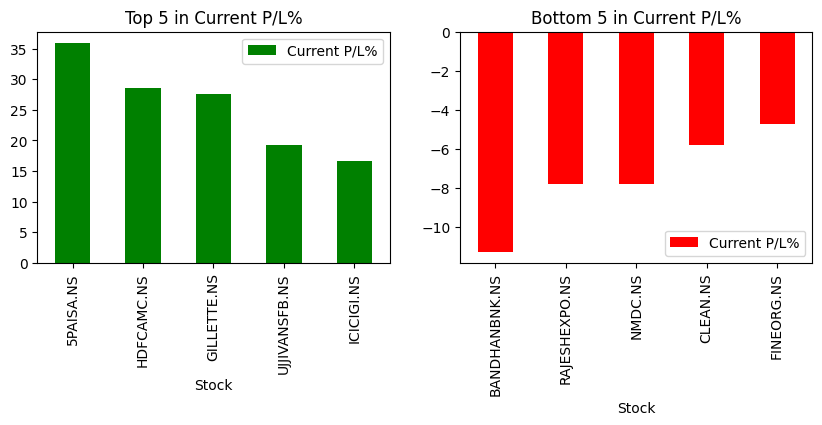

In [11]:
col = 'Current P/L%'
plot_features_top_bottom(df_portfolio_features, col)

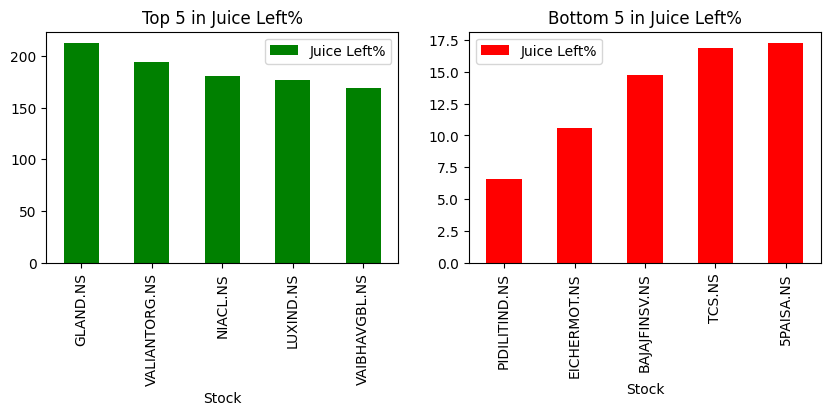

In [12]:
col = 'Juice Left%'
plot_features_top_bottom(df_portfolio_features, col)

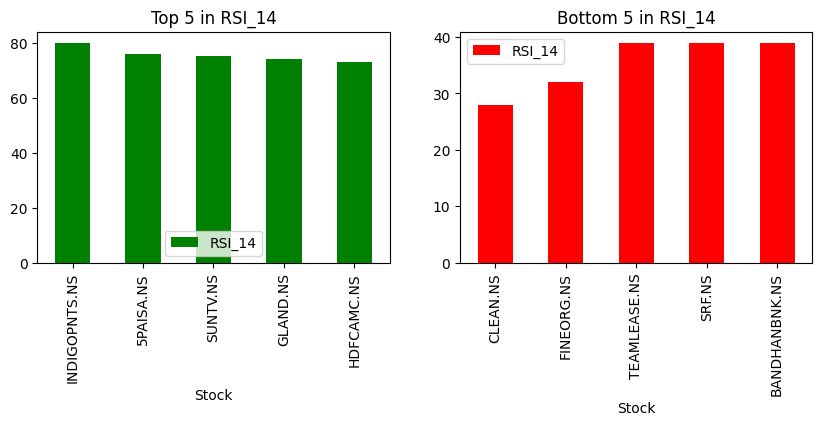

In [13]:
col = 'RSI_14'
plot_features_top_bottom(df_portfolio_features, col)

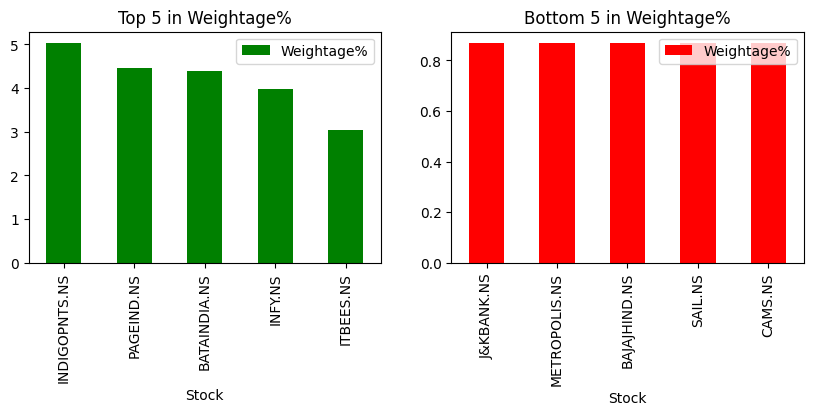

In [14]:
col = 'Weightage%'
plot_features_top_bottom(df_portfolio_features, col)

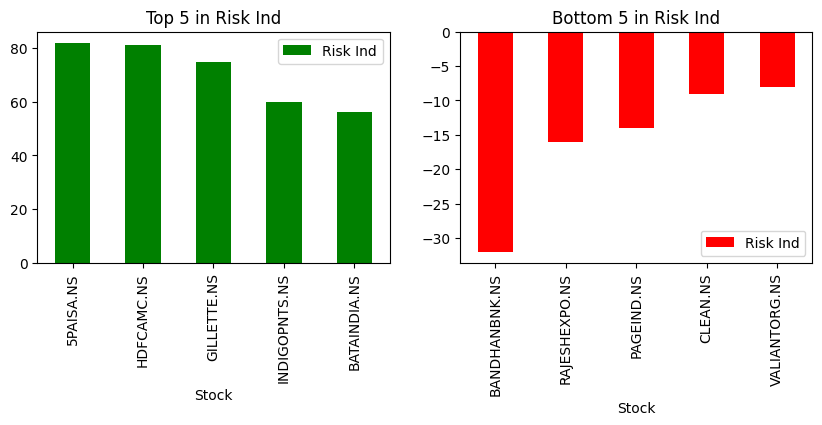

In [15]:
col = 'Risk Ind'
plot_features_top_bottom(df_portfolio_features, col)

In [16]:
def plot_feature_weights(df_portfolio_features, column):
  tmp_df = df_portfolio_features.groupby(column)['Weightage%'].agg(['sum'])
  tmp_df = tmp_df.rename({'sum': 'Weight%'}, axis='columns')
  tmp_df = tmp_df.sort_values(by = 'Weight%', ascending=False)
  tmp_df.plot.pie(y='Weight%', autopct='%1.0f%%', figsize=(5, 5), legend=False, title='Weight% in ' + column)

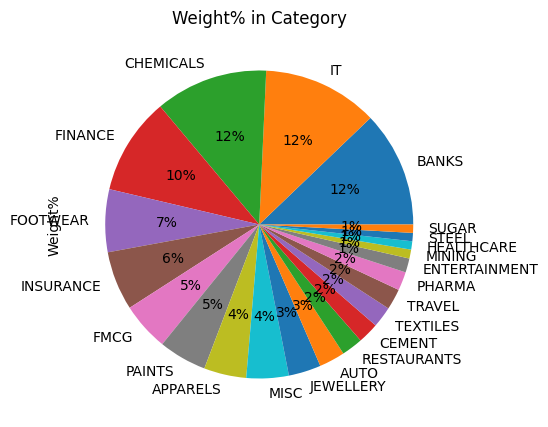

In [17]:
col = 'Category'
plot_feature_weights(df_portfolio_features, col)

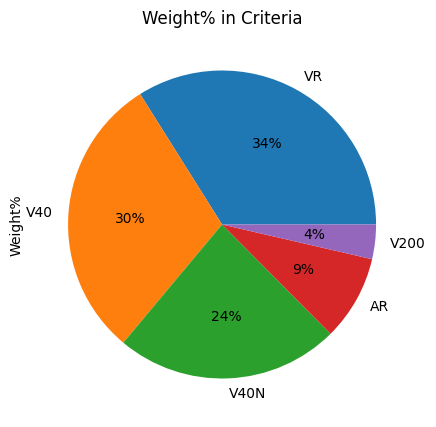

In [18]:
col = 'Criteria'
plot_feature_weights(df_portfolio_features, col)

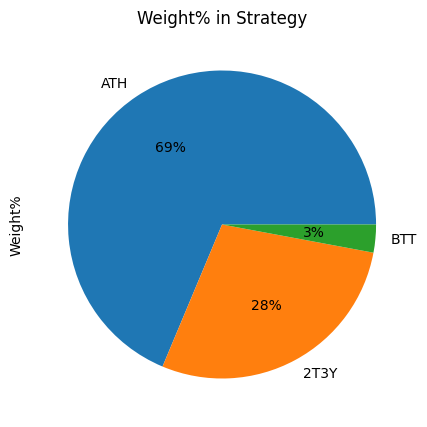

In [19]:
col = 'Strategy'
plot_feature_weights(df_portfolio_features, col)

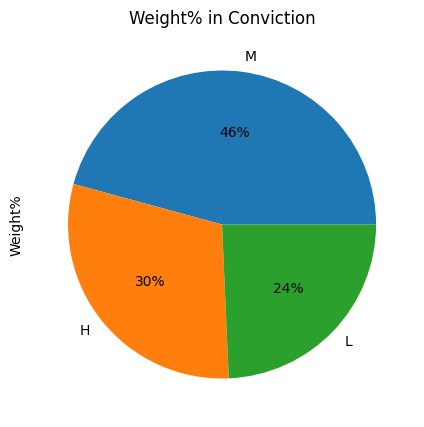

In [20]:
col = 'Conviction'
plot_feature_weights(df_portfolio_features, col)

In [21]:
#myts['Value'] = myts['Value'].str.replace(',', '').astype(float)

In [22]:
#sum(myts[(myts['Type'] == 'Buy')]['Value'])

In [23]:
#sum(myts[(myts['Type'] == 'Sell')]['Value'])